

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2022-10-04 19:55:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  42.1MB/s    in 5.2s    

2022-10-04 19:55:20 (38.8 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [5]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [19]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [20]:
import sklearn
from sklearn import metrics
from sklearn.linear_model import Ridge

rid = Ridge(alpha=10)
rid.fit(X_train, y_train)
y_pred = rid.predict(X_test)

print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred, squared=False))

Root Mean Squared Error: 9.510160746337895


In [21]:
#Наилучший константный прогноз - среднее арифметическое.
y_pred_2 = np.full(y_test.shape, y_train.mean())
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_2, squared=False))

Root Mean Squared Error: 10.85246390513634


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. 



In [22]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [23]:
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler()
scalerX.fit(X_train)

X_train = scalerX.transform(X_train) #масштабируем признаки
X_test = scalerX.transform(X_test)

scalerY = StandardScaler()
scalerY.fit(y_train.reshape(-1, 1))

y_train = scalerY.transform(y_train.reshape(-1, 1)) #нормируем таргет
#y_test не нормируем, так как в тесте будем считать метрику по исходным данным

In [24]:
class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {"sample": torch.tensor(self.x[idx, :], dtype=torch.float), "target": self.y[idx]}

In [25]:
set_random_seed(12)

train_set = AudioDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = AudioDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [26]:
model = nn.Sequential(
    nn.Linear(90, 125),  # линейный слой, преобразующий вектор размера 90 в вектор размера 125
    nn.ReLU(),               # нелинейность
    nn.Linear(125, 32),      # линейный слой, преобразующий вектор размера 125 в вектор размера 32
    nn.ReLU(),               # нелинейность
    nn.Linear(32, 64),       # линейный слой, преобразующий вектор размера 32 в вектор размера 64
    nn.ReLU(),               # нелинейность
    nn.Linear(64, 32),       # линейный слой, преобразующий вектор размера 64 в вектор размера 32
    nn.ReLU(),               # нелинейность
    nn.Linear(32, 1),       # линейный слой, преобразующий вектор размера 32 в вектор размера 1
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9) # создаем оптимизатор и передаем туда параметры модели
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) #https://pytorch.org/docs/stable/optim.html для оптимизации learning rate

In [27]:
def RMSELoss(yhat,y): #https://discuss.pytorch.org/t/rmse-loss-function/16540/2
    return torch.sqrt(torch.mean((yhat-y)**2))

criterion = RMSELoss

In [28]:
from IPython.display import clear_output 
import matplotlib.pyplot as plt

def plot_history(train_history, val_history, title="loss"): #для создания графиков
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [29]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epochs=5):
    train_loss_log, val_loss_log = [], []

    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss = torch.empty(0)
        model.train()
        for tren in tqdm(train_loader):

            X_train = tren['sample']
            y_train = tren['target']
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                cel = torch.tensor(scalerY.inverse_transform(y_pred.reshape(-1, 1)))
                func = torch.tensor(scalerY.inverse_transform(y_train.reshape(-1, 1)))
                lossik = criterion(cel, func)

                train_epoch_loss = torch.cat((train_epoch_loss, lossik.unsqueeze(0)))
                train_loss_log.append(lossik)

        scheduler.step()

        # валидация
        val_epoch_loss = torch.empty(0)
        model.eval()
        with torch.no_grad():
            for res in tqdm(test_loader):

                X_val = res['sample']
                y_val = res['target']
                y_pred_val = torch.tensor(scalerY.inverse_transform(model(X_val).reshape(-1, 1)))
                loss = criterion(y_pred_val, y_val)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.unsqueeze(0)))
              
        # печатаем метрики
        val_loss_log.append(val_epoch_loss.mean())
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        print("Train loss:", train_epoch_loss.mean())
        print("Val loss:", val_epoch_loss.mean())
        plt.plot(val_loss_log, label="train")
        plt.xlabel("epochs")
        plt.ylabel("validation loss")
        plt.show()
    #raise NotImplementedError


def test(model, criterion, test_loader):
    losstest = []
    k = 0
    with torch.no_grad():
        for res in tqdm(test_loader):

            X_t = res['sample']
            y_t = res['target']
            y_pred = torch.tensor(scalerY.inverse_transform(model(X_t).reshape(-1, 1)))

            if k == 0:
                predicts = y_pred
                k = 1
            else:
                predicts = torch.cat((predicts, y_pred), 0) #https://translated.turbopages.org/proxy_u/en-ru.ru.ea3b179e-6336ddb7-9f67ea1a-74722d776562/https/www.geeksforgeeks.org/how-to-join-tensors-in-pytorch/
    return predicts

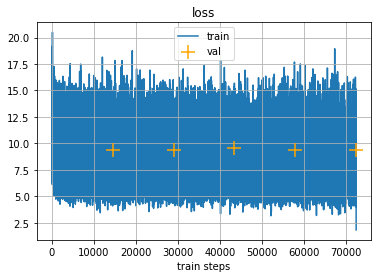

Train loss: tensor(8.2772, dtype=torch.float64)
Val loss: tensor(9.3994, dtype=torch.float64)


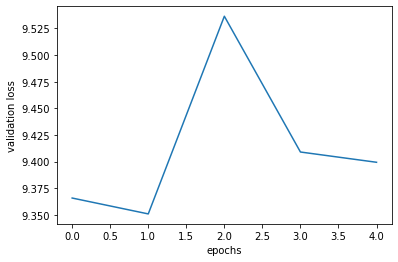

In [30]:
set_random_seed(12)

train(model, optimizer, criterion, train_loader, test_loader)

In [196]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}")

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.787639321091916


In [209]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") # scheduler

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.758411062194297


In [17]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") #lr=0.002

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.769575451932203


In [57]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") #lr=0.004

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.748816019492084


In [70]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") #weight_decay = 0.02

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.908378760137106


In [84]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}")

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.748816019492084


In [110]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") #8 epochs

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.803250505567295


In [123]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") #5 epoch, lr=0.004, 

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.748816019492084


In [136]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") #batch_size = 64 - not optim

  0%|          | 0/807 [00:00<?, ?it/s]

Итоговый Loss: 8.763225243117331


In [149]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") #batch_size = 16, batch_size = 32 - optimal

  0%|          | 0/3227 [00:00<?, ?it/s]

Итоговый Loss: 8.823752186145539


In [162]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") #momentum=0.7 - not optimal, 0.9 - optimal

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.771625303494751


In [269]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}") # 6 лин слоев

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.776142060814147


In [441]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}")

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.74936969690209


In [31]:
predicts = test(model, criterion, test_loader)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Итоговый Loss: {criterion(predicts, y_test_final)}")

  0%|          | 0/1614 [00:00<?, ?it/s]

Итоговый Loss: 8.74833940006348


In [283]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/1614 [00:00<?, ?it/s]

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**Первый эксперимент**: модель 4 слоя(90-128-64-90-32-1), lr = 0.005, кол-во эпох = 5, размер батча = 32

RMSE = 8.787639321091916

**Второй эксперимент**: модель 4 слоя(90-128-64-90-32-1), lr = 0.005, кол-во эпох = 5, размер батча = 32 + добавил scheduler для оптимизации lerning rate, нашел в инете, ссылку оставил.

RMSE = 8.758411062194297 шедулер оставляем.

**Третий эксперимент**: модель 4 слоя(90-128-64-90-32-1), кол-во эпох = 5, scheduler, размер батча = 32. Менял lr.

lr = 0.002: RMSE = 8.769575451932203

lr = 0.004: RMSE = 8.748816019492084 добились лучшего результата, следовательно, оптимальное значение lr = 0.004

**Четвертый эксперимент**: модель 4 слоя(90-128-64-90-32-1), кол-во эпох = 5, scheduler, lr = 0.004, размер батча = 32 + weight_decay = 0.02

RMSE = 8.908378760137106 не добавляем регуляризацию

**Пятый эксперимент**: модель 4 слоя(90-128-64-90-32-1), scheduler, lr = 0.004, размер батча = 32.

Кол-во эпох = 8: RMSE = 8.803250505567295, следовательно, оставляем число эпох равное 5.

**Шестой эксперимент**: модель 4 слоя(90-128-64-90-32-1), scheduler, lr = 0.004, количество эпох = 5. Меняю размер батча.

batch_size = 64: RMSE = 8.763225243117331
batch_size = 16: RMSE = 8.823752186145539

Следовательно, размер батча 32 - оптимальный.

**Седьмой эксперимент**: модель 4 слоя(90-128-64-90-32-1), scheduler, lr = 0.004, количество эпох = 5, размер батча = 32. Добавляю слой к модели.

RMSE = 8.776142060814147 добавочный слой убираем.

**Восьмой эксперимент**: модель 4 слоя(90-128-64-90-32-1), scheduler, lr = 0.004, количество эпох = 5, размер батча = 32. Меняю входные/выходные каналы. Много моделей попробовал, лосс то рос, то падал, минимальным был RMSE = 8.741 при каналах (90-128-32-64-32-1). Однако запуская их снова рмсе увеличивается, поэтому остановился на каналах (90-125-32-64-32-1) с RMSE = 8.74833940006348.








